# Create one coloc network per locus

In [1]:
library(pheatmap)
library(colorspace)


In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
dir.create("pipeline/5.9.coloc_network_only_eqtls", showWarnings = FALSE)


In [4]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [5]:
phenotypes  = qtl_list$phenotypes
qtls        = qtl_list$qtl
coordinates = exp_list$coordinates
rownames(coordinates) = coordinates$transcript_id

In [8]:
coloc_qtls = fread("pipeline/4.1.coloc_qtls/coloc.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [6]:
populations = c('meta','AFR','AMR','CSA','EAS','EUR','MID')

In [10]:
eqtl_coloc = list(isoform         = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.isoform.txt"      , sep = "\t", header = TRUE, data.table = FALSE),
                  gene            = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene.txt"         , sep = "\t", header = TRUE, data.table = FALSE),
                  isoform_vs_gene = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
                 )

# Get coloc between QTLs

In [31]:
coloc            = rbind(eqtl_coloc[["gene"]], eqtl_coloc[["isoform"]])
coloc            = coloc[ coloc$PP.H4.abf >= 0.8,]
coloc            = merge(coloc, coordinates[,c("transcript_id", "gene_id", "gene_name")], by.x = "transcript_id1", by.y = "transcript_id")
coloc            = merge(coloc, coordinates[,c("transcript_id", "gene_id", "gene_name")], by.x = "transcript_id2", by.y = "transcript_id", suffixes = 1:2)
coloc_dif        = coloc[ coloc$gene_id1 != coloc$gene_id2,]


In [50]:
coloc_dif_unique = unique(coloc_dif[,c("gene_id1", "gene_id2", "gene_name1", "gene_name2")])
coloc_dif_unique = cbind(coloc_dif_unique, as.data.frame(rbindlist(lapply(1:nrow(coloc_dif_unique), function(ii)
{
    id1 = coloc_dif_unique[ii, "gene_id1"]
    id2 = coloc_dif_unique[ii, "gene_id2"]
    x   = coloc[ coloc$gene_id1 == id1 & coloc$gene_id2 == id2,]
    x   = x[which.max(x$PP.H4.abf), c("transcript_id1", "transcript_id2", "type1", "type2", "id", "chrom", "pos", "ref", "alt", "af", "pp_snp", paste0("PP.H", 0:4, ".abf"))]
    
    return(x)
})), stringsAsFactors = FALSE))

In [333]:
fwrite(coloc_dif_unique, "pipeline/5.9.coloc_network_only_eqtls/coloc_dif_unique.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [59]:
counts = table(coloc_dif_unique$id)
counts = data.frame(id = names(counts), n = as.numeric(counts))
counts = counts[order(counts$n, decreasing = TRUE),]

nrow(counts)
nrow(counts[counts$n >   1,])
nrow(counts[counts$n >=  5,])
nrow(counts[counts$n >= 10,])

counts[ counts$n >= 10,]

[1] 2778

[1] 449

[1] 44

[1] 7

,id,n
,<chr>,<dbl>
1133,VAR_17_44173215_T_C,23
2427,VAR_7_102126545_C_CACTTTTT,19
882,VAR_16_29469615_CA_C,13
685,VAR_15_30910204_C_G,12
823,VAR_16_15147725_T_C,11
1795,VAR_22_24266831_G_C,11
1539,VAR_2_114357926_CCT_C,10


In [304]:
sort(unique(as.character(as.matrix(unique(coloc_dif_unique[ coloc_dif_unique$id == "VAR_17_44173215_T_C", c("gene_name1", "gene_name2")])))))
sort(unique(as.character(as.matrix(unique(coloc_dif_unique[ coloc_dif_unique$id == "VAR_7_102126545_C_CACTTTTT", c("gene_name1", "gene_name2")])))))
sort(unique(as.character(as.matrix(unique(coloc_dif_unique[ coloc_dif_unique$id == "VAR_16_29469615_CA_C", c("gene_name1", "gene_name2")])))))


[1] "ARL17A"     "ARL17B"     "FAM215B"    "KANSL1"     "KANSL1-AS1"
[6] "LRRC37A"    "LRRC37A2"

[1] "AC105052.3" "POLR2J2"    "POLR2J3"    "PRKRIP1"    "RASA4"     
[6] "RASA4B"     "UPK3BL1"

[1] "AC133555.5"    "BOLA2"         "BOLA2-SMG1P6"  "LAT"          
[5] "RP11-231C14.4" "SLX1B"         "SMG1P2"

# chr17 and COVID-19
- rs74521229 (lead variant of eQTLs)
- lead variants for COVID-19 colocalization with eQTLs: rs7221167; rs7225002; rs4510068
- rs74521229 is in high LD (high D') with rs7225002 and rs4510068


# Are eGenes that share eQTLs more likely to be cell type-specific?

In [311]:
gene2n = rbind(data.frame(gene_id = coloc_dif_unique$gene_id1, id = coloc_dif_unique$id), 
               data.frame(gene_id = coloc_dif_unique$gene_id2, id = coloc_dif_unique$id)
              )
gene2n = merge(gene2n, counts)
gene2n = aggregate(n ~ gene_id, data = gene2n, FUN = max)

In [322]:
totest = merge(qtl_list$interactions$rna, gene2n, all.x = TRUE)
totest[is.na(totest$n) == TRUE, "n"] = 0
totest$cell = as.numeric(totest$cell)

In [332]:
test_ct = function(cell, totest)
{
    x    = totest[ totest$interaction == cell,]
    test = coefficients(summary(lm(n ~ cell, data = x)))
    out  = data.frame(cell = cell, beta = test[2, "Estimate"], se = test[2, "Std. Error"], pval = test[2, "Pr(>|t|)"])
    
    return(out)
}

cells = sort(unique(totest$interaction))
tests_cell = as.data.frame(rbindlist(lapply(cells, function(cell){test_ct(cell, totest)})), stringsAsFactors = FALSE)

fwrite(tests_cell, "pipeline/5.9.coloc_network_only_eqtls/enrichment_by_cell.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [331]:
tests_cell

cell,beta,se,pval
<chr>,<dbl>,<dbl>,<dbl>
adult,0.6115061792,0.07167738,1.559311e-17
arteria,0.3722662052,0.06984068,9.927396e-08
arteria_aorta,0.2351492636,0.08333715,4.782775e-03
arteria_coronary,0.1499352747,0.18673519,4.220258e-01
cibersort.regular.cardiac_muscle,0.2641887785,0.08103064,1.114786e-03
cibersort.regular.cardiac_neuron,-0.1966318242,0.16028976,2.199411e-01
cibersort.regular.endocardial,0.0544040804,0.18886179,7.733019e-01
cibersort.regular.endothelial,-0.1706229283,0.53001641,7.475170e-01
cibersort.regular.fibroblast,0.7946037099,0.11404459,3.338070e-12


# Are eVariants associated with multiple eGenes more likely to be associated with the same cell type associations?

In [338]:
str(coloc_dif_unique)


'data.frame':	3622 obs. of  20 variables:
 $ gene_id1      : chr  "ENSG00000001460.18_7" "ENSG00000007516.14_6" "ENSG00000006194.10_5" "ENSG00000006282.21_8" ...
 $ gene_id2      : chr  "ENSG00000001461.17_4" "ENSG00000007520.4_5" "ENSG00000010539.11_7" "ENSG00000011052.21_4" ...
 $ gene_name1    : chr  "STPG1" "BAIAP3" "ZNF263" "SPATA20" ...
 $ gene_name2    : chr  "NIPAL3" "TSR3" "ZNF200" "NME1-NME2" ...
 $ transcript_id1: chr  "ENSG00000001460.18_7" "ENSG00000007516.14_6" "ENSG00000006194.10_5" "ENSG00000006282.21_8" ...
 $ transcript_id2: chr  "ENSG00000001461.17_4" "ENSG00000007520.4_5" "ENSG00000010539.11_7" "ENSG00000011052.21_4" ...
 $ type1         : int  0 1 0 2 0 1 0 2 0 1 ...
 $ type2         : int  0 0 0 0 1 0 1 0 1 0 ...
 $ id            : chr  "VAR_1_24743783_C_T" "VAR_16_1393851_GCTGGGACAGGCCGT_G" "VAR_16_3340845_C_T" "VAR_17_49043348_C_T" ...
 $ chrom         : int  1 16 16 17 17 6 16 11 17 22 ...
 $ pos           : int  24743783 1393851 3340845 49043348 40812797 11189

In [366]:
perm_test = function(x)
{
    x$cell1 = sample(x$cell1)
    x$cell2 = sample(x$cell2)
    score   = nrow(x[ rowSums(x[,c("cell1", "cell2")]) == 2,]) / nrow(x[ rowSums(x[,c("cell1", "cell2")]) >= 1,])

    return(score)
}

test_cell_var = function(cell, celldata, coloc_dif_unique)
{
    gene_ids = unique(celldata[ celldata$interaction == cell & celldata$cell == TRUE, "gene_id"])
    x        = coloc_dif_unique
    x$cell1  = 0
    x$cell2  = 0
    x[x$gene_id1 %in% gene_ids, "cell1"] = 1
    x[x$gene_id2 %in% gene_ids, "cell2"] = 1
    
    score = nrow(x[ rowSums(x[,c("cell1", "cell2")]) == 2,]) / nrow(x[ rowSums(x[,c("cell1", "cell2")]) >= 1,])
    
    permdata = unlist(lapply(1:100, function(ii){perm_test(x)}))
    
    out = data.frame(cell      = cell, 
                     score     = score, 
                     n         = nrow(x[ rowSums(x[,c("cell1", "cell2")]) == 2,]), 
                     perm_mean = mean(permdata),
                     perm_sd   = sd  (permdata)
                    )
    
    return(out)
}

celldata          = rbind(qtl_list$interactions$rna, qtl_list$interactions$isoform)
cells_perm        = as.data.frame(rbindlist(lapply(cells, function(cell){test_cell_var(cell, celldata, coloc_dif_unique)})), stringsAsFactors = FALSE)
cells_perm$zscore = (cells_perm$score - cells_perm$perm_mean) / cells_perm$perm_sd
cells_perm$pval   = 2 * pnorm(q = -abs(cells_perm$zscore))

fwrite(cells_perm, "pipeline/5.9.coloc_network_only_eqtls/enrichment_by_cell_permutations.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [367]:
cells_perm

cell,score,n,perm_mean,perm_sd,zscore,pval
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
adult,0.12140992,93,0.063492867,0.007914488,7.3178525,2.519705e-13
arteria,0.12670300,93,0.060685487,0.008991355,7.3423315,2.099047e-13
arteria_aorta,0.09205021,44,0.036510005,0.008934774,6.2161845,5.093891e-10
arteria_coronary,0.00000000,0,0.005865407,0.006965354,-0.8420831,3.997415e-01
cibersort.regular.cardiac_muscle,0.10561798,47,0.035293422,0.008595663,8.1814001,2.805645e-16
cibersort.regular.cardiac_neuron,0.00000000,0,0.008088903,0.008993802,-0.8993863,3.684469e-01
cibersort.regular.endocardial,0.02752294,3,0.006345891,0.007620093,2.7791058,5.450877e-03
cibersort.regular.endothelial,0.00000000,0,0.000000000,0.000000000,NaN,NaN
cibersort.regular.fibroblast,0.08776596,33,0.029170061,0.007774638,7.5368010,4.816404e-14


# Are eQTLs shared between genes more likely to overlap regulatory elements expressed in many tissues? YES
- look for overlap with Roadmap ChromHMM
- compare with: lead variants for other genes (not shared between genes); and non-eQTL lead variants

In [62]:
qtls      = rbind(qtl_list[["qtl"]][["rna"]], qtl_list[["qtl"]][["isoform"]])
qtls_rest = qtls[!qtls$gene_id %in% c(coloc_dif_unique$gene_id1, coloc_dif_unique$gene_id2),]


In [114]:
qtl2test = counts
qtl2test$bin = 1
qtl2test[qtl2test$n >=  2, "bin"] =  2
qtl2test[qtl2test$n >=  5, "bin"] =  5
qtl2test[qtl2test$n >= 10, "bin"] = 10

qtl2test       = rbind(qtl2test, data.frame(id = qtls_rest[! qtls_rest$id %in% qtl2test$id & qtls_rest$egene == TRUE                                                                        , "id"], n =  0, bin =  0))
qtl2test       = rbind(qtl2test, data.frame(id = qtls_rest[! qtls_rest$id %in% qtl2test$id & qtls_rest$egene == FALSE & qtls_rest$type == 0 & grepl("ENSG", qtls_rest$transcript_id) == TRUE, "id"], n = -1, bin = -1))
qtl2test$chrom = paste0("chr", unlist(lapply(qtl2test$id, function(x){unlist(strsplit(x, "_"))[[2]]})))
qtl2test$pos   = as.numeric(   unlist(lapply(qtl2test$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
qtl2test       = unique(qtl2test)

In [115]:
qtl2test_bed    = "pipeline/5.9.coloc_network_only_eqtls/qtl2test.bed"
roadmap_files   = list.files(path = "/frazer01/reference/public/RoadmapEpigenomics/ChmmModels", pattern = "_15_coreMarks_segments.bed", full.names = TRUE)
intersected_bed = "pipeline/5.9.coloc_network_only_eqtls/intersected.bed"

In [116]:
roadmap = data.frame(file = roadmap_files, eid = unlist(lapply(roadmap_files, function(x)
{
    x = unlist(strsplit(x, "/"))
    x = x[[length(x)]]
    return(sub("_15_coreMarks_segments.bed", "", x))
})))

rownames(roadmap) = roadmap$eid

In [117]:
fwrite(qtl2test[order(qtl2test$chrom, qtl2test$pos), c("chrom", "pos", "pos", "id", "n", "bin")], qtl2test_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

In [118]:
table(qtl2test$bin)
str(qtl2test)



   -1     0     1     2     5    10 
 7525 15060  2329   405    37     7 

'data.frame':	25363 obs. of  5 variables:
 $ id   : chr  "VAR_17_44173215_T_C" "VAR_7_102126545_C_CACTTTTT" "VAR_16_29469615_CA_C" "VAR_15_30910204_C_G" ...
 $ n    : num  23 19 13 12 11 11 10 9 8 8 ...
 $ bin  : num  10 10 10 10 10 10 10 5 5 5 ...
 $ chrom: chr  "chr17" "chr7" "chr16" "chr15" ...
 $ pos  : num  4.42e+07 1.02e+08 2.95e+07 3.09e+07 1.51e+07 ...


In [119]:
command_intersect = paste("bedtools", "intersect", "-loj", "-filenames",
                          "-a", qtl2test_bed, paste("-b", roadmap_files, collapse = " "),
                          ">", intersected_bed
                         )

system(command_intersect)

In [120]:
intersected           = fread(intersected_bed, sep = "\t", header = FALSE, data.table = FALSE)
colnames(intersected) = c("chrom", "pos", "pos2", "id", "n", "bin", "file", "chrom2", "from", "to", "mark")
intersected$mark      = as.numeric(sub("E", "", intersected$mark))

intersected[,c("pos2", "chrom2", "from", "to")] = NULL

str(intersected)

'data.frame':	3222425 obs. of  7 variables:
 $ chrom: chr  "chr1" "chr1" "chr1" "chr1" ...
 $ pos  : int  63735 63735 63735 63735 63735 63735 63735 63735 63735 63735 ...
 $ id   : chr  "VAR_1_63735_CCTA_C" "VAR_1_63735_CCTA_C" "VAR_1_63735_CCTA_C" "VAR_1_63735_CCTA_C" ...
 $ n    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ bin  : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ file : chr  "/frazer01/reference/public/RoadmapEpigenomics/ChmmModels/E027_15_coreMarks_segments.bed" "/frazer01/reference/public/RoadmapEpigenomics/ChmmModels/E011_15_coreMarks_segments.bed" "/frazer01/reference/public/RoadmapEpigenomics/ChmmModels/E014_15_coreMarks_segments.bed" "/frazer01/reference/public/RoadmapEpigenomics/ChmmModels/E016_15_coreMarks_segments.bed" ...
 $ mark : num  14 15 15 15 15 15 15 15 15 15 ...


In [123]:
qtl2mark           = unique(intersected[, c("chrom", "pos", "id", "n", "bin")])
rownames(qtl2mark) = qtl2mark$id

for(eid in roadmap$eid)
{
    infile         = roadmap[eid, "file"]
    qtl2mark[,eid] = 15
    todata         = intersected[ intersected$file == infile,]
    
    qtl2mark[ todata$id, eid] = todata$mark
}



In [158]:
states           = fread("/frazer01/reference/private/chromhmm_states.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(states) = c("mark", "mark_id", "description", "color_name", "color_code")
states$color_r   = as.hexmode(as.numeric(lapply(states$color_code, function(x){unlist(strsplit(x, ","))[[1]]})))
states$color_g   = as.hexmode(as.numeric(lapply(states$color_code, function(x){unlist(strsplit(x, ","))[[2]]})))
states$color_b   = as.hexmode(as.numeric(lapply(states$color_code, function(x){unlist(strsplit(x, ","))[[3]]})))
states$color     = paste0("#", states$color_r, states$color_g, states$color_b)
states           = states[,c("mark", "mark_id", "description", "color")]
states$activity  = "active"
rownames(states) = paste0("E", states$mark)

states[ states$mark %in% c(9, 13:15), "activity"] = "repressed"
states[ states$mark %in% 10:12      , "activity"] = "bivalent"

fwrite(states, "pipeline/chromatin_states.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

activities = sort(unique(states$activity))

In [162]:
qtl2mark_by_mark = qtl2mark[, c("chrom", "pos", "id", "n", "bin")]

qtl2mark_by_mark[, paste0("E", 1:15)] = 0
qtl2mark_by_mark[, activities       ] = 0

for(id in qtl2mark_by_mark$id)
{
    indata   = paste0("E", as.numeric(qtl2mark[id, roadmap$eid]))
    to_state = table(indata)
    
    for(activity in activities)
    {
        qtl2mark_by_mark[id, activity] = length(indata[indata %in% rownames(states[states$activity == activity, ])]) / nrow(roadmap)
    }

    
    qtl2mark_by_mark[id, names(to_state)] = as.numeric(to_state) / nrow(roadmap)
}



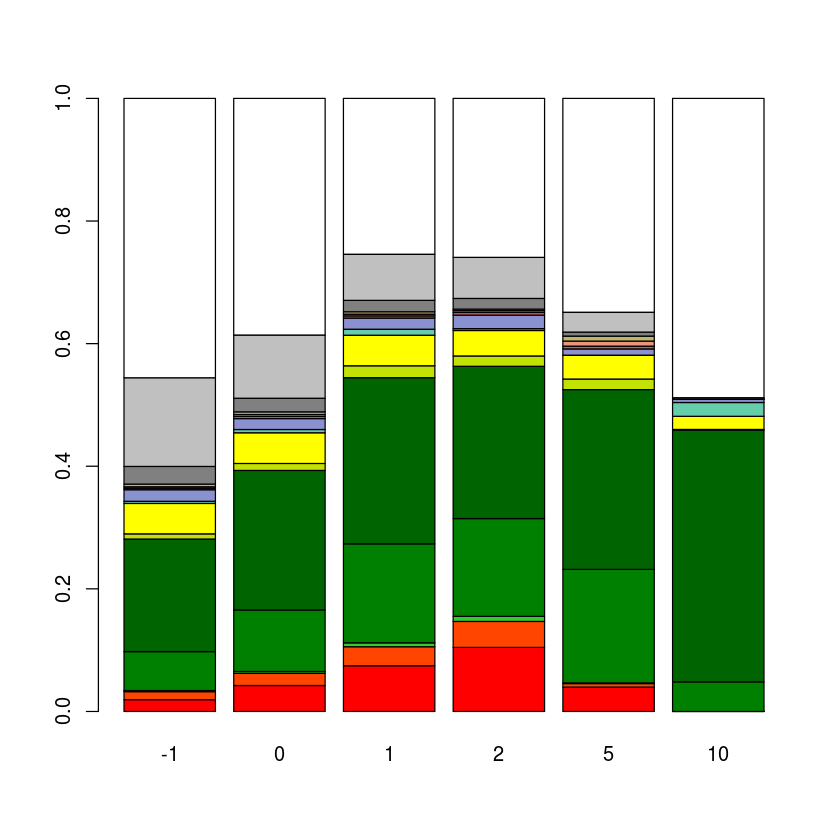

In [150]:
toplot_by_state = aggregate(. ~ bin, data = qtl2mark_by_mark[,c("bin", paste0("E", 1:15))], FUN = mean)

barplot(t(as.matrix(toplot_by_state[,rownames(states)])), names.arg = toplot$bin, col = states$color)

In [196]:
summary(lm(active    ~ n, data = qtl2mark_by_mark                               ))$coefficients
summary(lm(active    ~ n, data = qtl2mark_by_mark[qtl2mark_by_mark$active >  0,]))$coefficients
summary(lm(active    ~ n, data = qtl2mark_by_mark[qtl2mark_by_mark$bin    >= 0,]))$coefficients

t.test(qtl2mark_by_mark[qtl2mark_by_mark$bin > 0, "active"], qtl2mark_by_mark[qtl2mark_by_mark$bin == 0, "active"])



,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.45750376,0.002378273,192.36802,0.000000e+00
n,0.09421947,0.003065186,30.73859,9.495561e-204


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.48480266,0.002411360,201.04946,0.000000e+00
n,0.09203469,0.003099556,29.69286,2.766822e-190


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.47153516,0.002985545,157.93938,0.000000e+00
n,0.06772697,0.004531209,14.94678,3.291896e-50



	Welch Two Sample t-test

data:  qtl2mark_by_mark[qtl2mark_by_mark$bin > 0, "active"] and qtl2mark_by_mark[qtl2mark_by_mark$bin == 0, "active"]
t = 20.869, df = 3865.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1475114 0.1781014
sample estimates:
mean of x mean of y 
0.6227388 0.4599324 


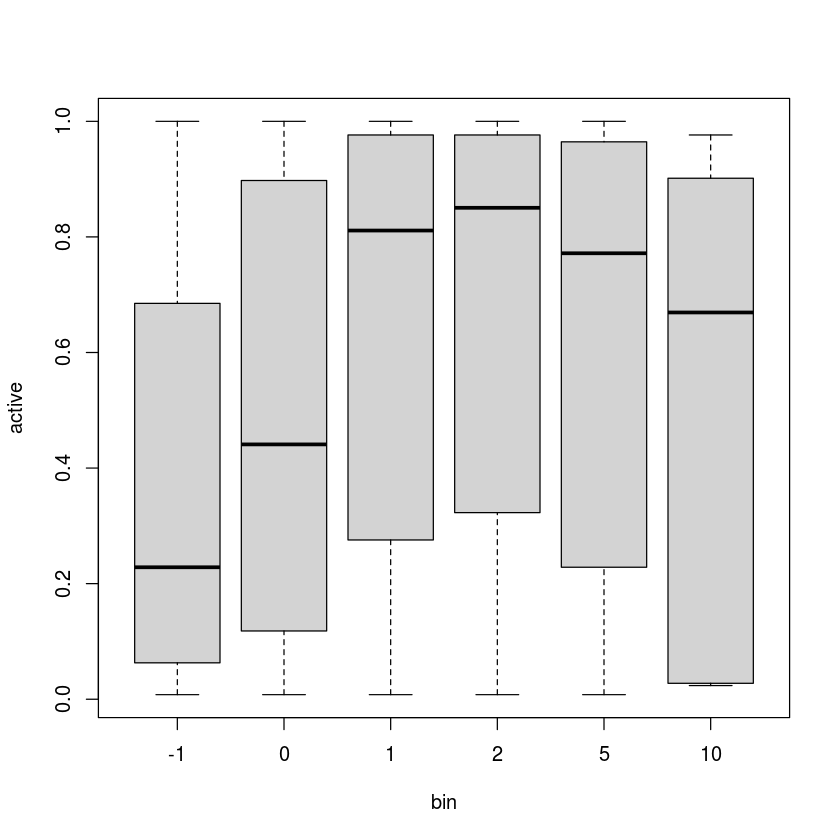

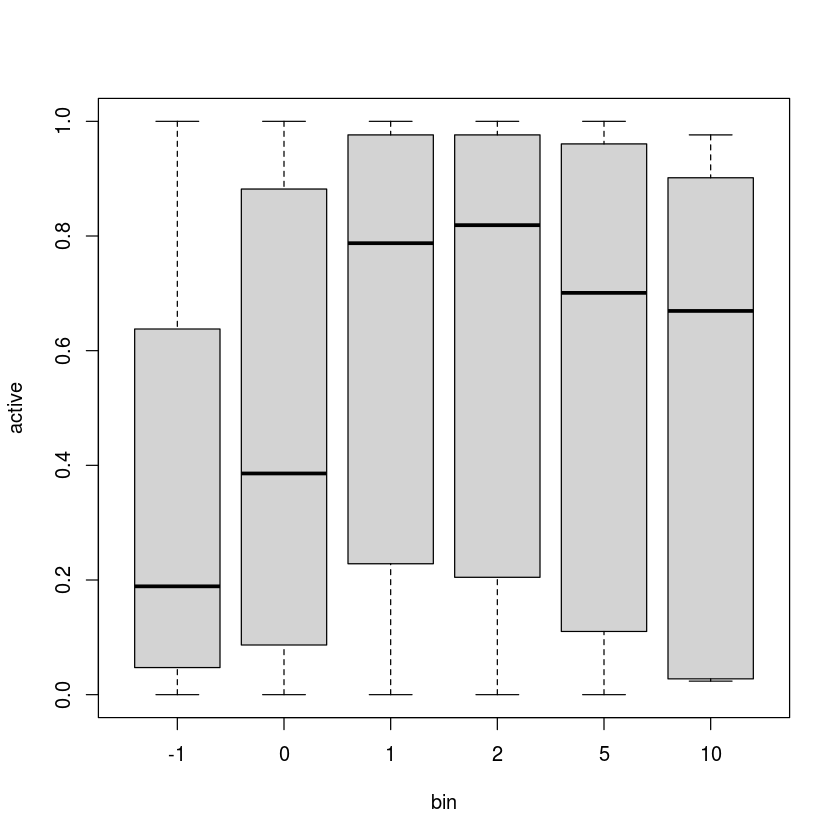

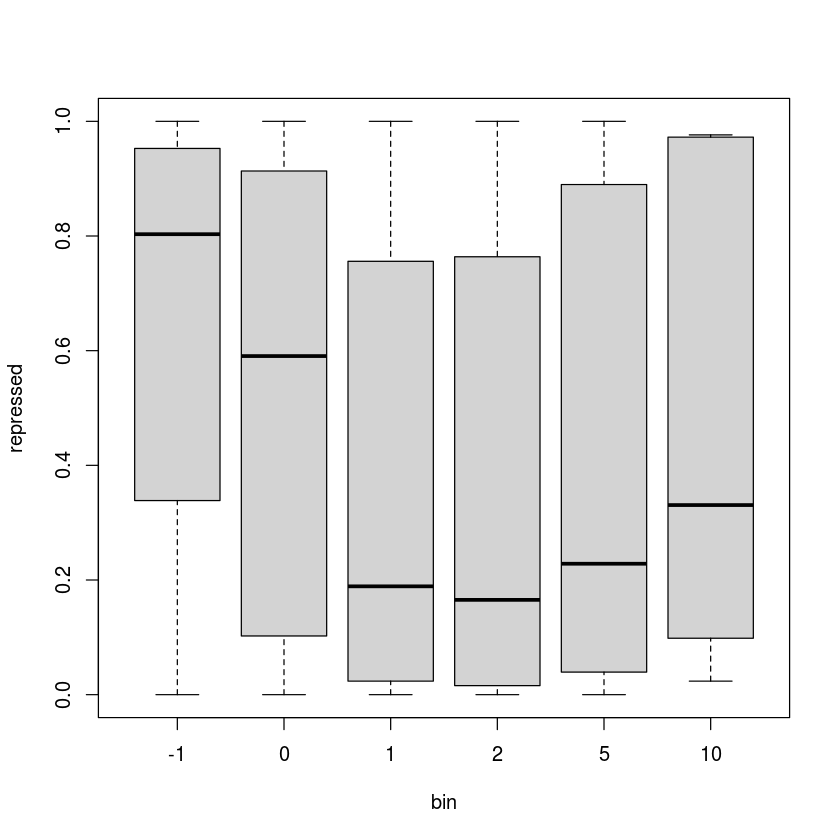

In [202]:
boxplot(active    ~ bin, data = qtl2mark_by_mark[qtl2mark_by_mark$active > 0,])
boxplot(active    ~ bin, data = qtl2mark_by_mark)
boxplot(repressed ~ bin, data = qtl2mark_by_mark)


# Are eQTLs shared between multiple eGenes more likely to overlap HiC anchors? And anchors with multiple loops? NO: they are just more likely to overlap anchors than negative controls

In [175]:
loops       = fread("/frazer01/projects/CARDIPS/analysis/hic_paper/loop_coordinates_ipsc_cvpc.txt", sep = "\t", header = TRUE, data.table = FALSE)
anchors     = data.frame(chrom = c(loops$chrA, loops$chrB), from = c(loops$startA, loops$startB), to = c(loops$endA, loops$endB))
anchors     = anchors[order(anchors$chrom, anchors$from, anchors$to),]
anchors_bed = "pipeline/5.9.coloc_network_only_eqtls/loop_anchors.bed"

fwrite(anchors, anchors_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

In [186]:
intersected_anchors_bed = "pipeline/5.9.coloc_network_only_eqtls/intersected_anchors.bed"
command_intersect       = paste("bedtools", "intersect", 
                                "-a", qtl2test_bed, 
                                "-b", anchors_bed,
                                "-c",
                                ">" , intersected_anchors_bed
                               )

system(command_intersect)

In [187]:
qtl2anchor           = fread(intersected_anchors_bed, sep = "\t", header = FALSE, data.table = FALSE)
colnames(qtl2anchor) = c("chrom", "pos", "pos2", "id", "n", "bin", "anchors")


In [199]:
fisher.test(matrix(c(nrow(qtl2anchor[qtl2anchor$bin >  -1 & qtl2anchor$anchors >  0,]),
                     nrow(qtl2anchor[qtl2anchor$bin >  -1 & qtl2anchor$anchors == 0,]),
                     nrow(qtl2anchor[qtl2anchor$bin == -1 & qtl2anchor$anchors >  0,]),
                     nrow(qtl2anchor[qtl2anchor$bin == -1 & qtl2anchor$anchors == 0,])
                    ), nrow = 2, byrow = TRUE))

fisher.test(matrix(c(nrow(qtl2anchor[qtl2anchor$bin >  0 & qtl2anchor$anchors >  0,]),
                     nrow(qtl2anchor[qtl2anchor$bin >  0 & qtl2anchor$anchors == 0,]),
                     nrow(qtl2anchor[qtl2anchor$bin == 0 & qtl2anchor$anchors >  0,]),
                     nrow(qtl2anchor[qtl2anchor$bin == 0 & qtl2anchor$anchors == 0,])
                    ), nrow = 2, byrow = TRUE))


t.test(qtl2anchor[qtl2anchor$bin >  0, "anchors"], qtl2anchor[qtl2anchor$bin ==  0, "anchors"])
t.test(qtl2anchor[qtl2anchor$bin >= 0, "anchors"], qtl2anchor[qtl2anchor$bin == -1, "anchors"])



	Fisher's Exact Test for Count Data

data:  matrix(c(nrow(qtl2anchor[qtl2anchor$bin > -1 & qtl2anchor$anchors > 0, ]), nrow(qtl2anchor[qtl2anchor$bin > -1 & qtl2anchor$anchors == 0, ]), nrow(qtl2anchor[qtl2anchor$bin == -1 & qtl2anchor$anchors > 0, ]), nrow(qtl2anchor[qtl2anchor$bin == -1 & qtl2anchor$anchors == 0, ])), nrow = 2, byrow = TRUE)
p-value = 0.0002021
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.081856 1.297410
sample estimates:
odds ratio 
  1.184319 



	Fisher's Exact Test for Count Data

data:  matrix(c(nrow(qtl2anchor[qtl2anchor$bin > 0 & qtl2anchor$anchors > 0, ]), nrow(qtl2anchor[qtl2anchor$bin > 0 & qtl2anchor$anchors == 0, ]), nrow(qtl2anchor[qtl2anchor$bin == 0 & qtl2anchor$anchors > 0, ]), nrow(qtl2anchor[qtl2anchor$bin == 0 & qtl2anchor$anchors == 0, ])), nrow = 2, byrow = TRUE)
p-value = 0.0005699
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6843192 0.9054918
sample estimates:
odds ratio 
 0.7883653 



	Welch Two Sample t-test

data:  qtl2anchor[qtl2anchor$bin > 0, "anchors"] and qtl2anchor[qtl2anchor$bin == 0, "anchors"]
t = -4.9745, df = 4498.5, p-value = 6.786e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05723447 -0.02487453
sample estimates:
mean of x mean of y 
0.1108711 0.1519256 



	Welch Two Sample t-test

data:  qtl2anchor[qtl2anchor$bin >= 0, "anchors"] and qtl2anchor[qtl2anchor$bin == -1, "anchors"]
t = 3.1276, df = 15009, p-value = 0.001766
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.007100114 0.030940651
sample estimates:
mean of x mean of y 
0.1455320 0.1265116 


In [205]:
summary(lm(anchors ~ n, data = qtl2anchor[qtl2anchor$bin >= 0,]))$coefficients
summary(lm(anchors ~ n, data = qtl2anchor                      ))$coefficients


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.1492148,0.003637500,41.021247,0.000000000
n,-0.0181374,0.005520691,-3.285349,0.001020525


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.1398257222,0.002909162,48.0639201,0.0000000
n,-0.0004099945,0.003749410,-0.1093491,0.9129265


## Distance from anchors

In [206]:
intersected_anchors_dis = "pipeline/5.9.coloc_network_only_eqtls/intersected_anchors.bed"
command_intersect       = paste("bedtools", "closest", 
                                "-d", "-t", "first",
                                "-a", qtl2test_bed, 
                                "-b", anchors_bed,
                                ">" , intersected_anchors_dis
                               )

system(command_intersect)

In [209]:
qtl2dis           = fread(intersected_anchors_dis, sep = "\t", header = FALSE, data.table = FALSE)
colnames(qtl2dis) = c("chrom", "pos", "pos2", "id", "n", "bin", "chr2", "from2", "to2", "distance")

qtl2dis[,c("chr2", "from2", "to2")] = NULL

In [212]:
qtl2dis_test = qtl2dis[ qtl2dis$distance <= 1000000,]

t.test(qtl2dis_test[qtl2dis_test$bin >  0, "distance"], qtl2dis_test[qtl2dis_test$bin ==  0, "distance"])
t.test(qtl2dis_test[qtl2dis_test$bin >= 0, "distance"], qtl2dis_test[qtl2dis_test$bin == -1, "distance"])



	Welch Two Sample t-test

data:  qtl2dis_test[qtl2dis_test$bin > 0, "distance"] and qtl2dis_test[qtl2dis_test$bin == 0, "distance"]
t = 5.2133, df = 3072.1, p-value = 1.978e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  6382.188 14076.837
sample estimates:
mean of x mean of y 
 52791.76  42562.25 



	Welch Two Sample t-test

data:  qtl2dis_test[qtl2dis_test$bin >= 0, "distance"] and qtl2dis_test[qtl2dis_test$bin == -1, "distance"]
t = -1.3453, df = 15153, p-value = 0.1786
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3079.4089   572.8357
sample estimates:
mean of x mean of y 
 44092.18  45345.46 


In [213]:
summary(lm(distance ~ n, data = qtl2dis_test[qtl2dis_test$bin >= 0,]))$coefficients
summary(lm(distance ~ n, data = qtl2dis_test                        ))$coefficients


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),42234.685,560.3860,75.36713,0.000000e+00
n,9589.422,870.0291,11.02196,3.701389e-28


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),45106.651,449.3549,100.380904,0.000000e+00
n,3956.075,585.3884,6.758034,1.429373e-11


# Are eQTLs shared by multiple genes more likely to overlap or be close to GWAS hotspots
- GWAS hotspots: region with multiple associations
- Divide genome into bins, then do correlation by bin

## Divide genome into bins

In [219]:
genome_bins = "pipeline/5.9.coloc_network_only_eqtls/genome_1mb_bins.bed"
chrom_sizes = "/frazer01/reference/public/hg19/hg19.size.txt"
command_bin = paste("bedtools", "makewindows", 
                    "-g", chrom_sizes, 
                    "-w", "1000000",
                    ">" , genome_bins)

system(command_bin)

## Make a bed file with all the GWAS catalog data

In [232]:
library(tidyr)
library(dplyr)

In [220]:
gwas = fread("/frazer01/reference/public/gwas_catalog/alternative", sep = "\t", header = TRUE, data.table = FALSE)

In [266]:
gwas_bed_hg38      = "pipeline/5.9.coloc_network_only_eqtls/gwas_hg38.bed"
gwas2bed           = gwas[,c("CHR_ID", "CHR_POS", "P-VALUE", "MAPPED_TRAIT")]
colnames(gwas2bed) = c("chrom", "pos", "pval", "trait")
gwas2bed$pval      = as.numeric(tolower(gwas2bed$pval))
gwas2bed           = gwas2bed[ gwas2bed$pval <= 5e-8,]
gwas2bed           = as.data.frame(gwas2bed %>% separate_rows(chrom, pos))
gwas2bed           = unique(gwas2bed[ gwas2bed$chrom %in% as.character(1:22), c("chrom", "pos", "trait")])
gwas2bed$pos       = as.numeric(gwas2bed$pos)
gwas2bed$chrom     = paste0("chr", gwas2bed$chrom)
gwas2bed           = gwas2bed[order(gwas2bed$chrom, gwas2bed$pos),]
gwas2bed$end       = gwas2bed$pos + 1
fwrite(gwas2bed[,c("chrom", "pos", "end")], gwas_bed_hg38, sep = "\t", col.names = FALSE, row.names = FALSE)

In [268]:
gwas_bed_hg19    = sub("hg38", "hg19", gwas_bed_hg38)
liftover         = "/software/ucsc.linux.x86_64.20151103/liftOver"
chain_file       = "/frazer01/reference/private/hg38ToHg19.over.chain"
command_liftover = paste(liftover, gwas_bed_hg38, chain_file, gwas_bed_hg19, "unMapped")

system(command_liftover)


## Assign GWAS and eQTL data to bins

In [270]:
assign_to_bin = function(bed)
{
    out_bed = sub("bed$", "bin.bed", bed)
    command_intersect = paste("bedtools", "intersect", "-loj",
                              "-a", bed, 
                              "-b", genome_bins,
                              ">" , out_bed
                             )

    system(command_intersect)
    
    return(out_bed)
}

gwas_bin_bed     = assign_to_bin(gwas_bed_hg19)
qtl2test_bin_bed = assign_to_bin(qtl2test_bed )


In [271]:
bin2gwas           = fread(gwas_bin_bed, sep = "\t", header = FALSE, data.table = FALSE)
colnames(bin2gwas) = c("traits", "na1", "na2", "chrom", "from", "to")
bin2gwas           = aggregate(traits ~ chrom + from + to, data = bin2gwas, FUN = length)
bin2gwas$gbin      = paste(bin2gwas$chrom, bin2gwas$from, bin2gwas$to, sep = "_")

In [283]:
bin2eqtl           = fread(qtl2test_bin_bed, sep = "\t", header = FALSE, data.table = FALSE)
colnames(bin2eqtl) = c("chrom", "pos", "pos2", "id", "n", "bin", "chrom2", "from", "to")
bin2eqtl$gbin      = paste(bin2eqtl$chrom2, bin2eqtl$from, bin2eqtl$to, sep = "_")
bin2eqtl           = bin2eqtl[, c("chrom", "pos", "id", "n", "bin", "from", "to", "gbin")]
bin2eqtl           = merge(bin2eqtl, bin2gwas[,c("gbin", "traits")], all.x = TRUE)

bin2eqtl[is.na(bin2eqtl$traits) == TRUE, "traits"] = 0

In [285]:
summary(lm(traits ~ n, data = bin2eqtl[bin2eqtl$bin >= 0,]))$coefficients
summary(lm(traits ~ n, data = bin2eqtl                    ))$coefficients


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),54.49821,0.7104856,76.70558,0.000000e+00
n,24.49942,1.0783152,22.72009,1.123002e-112


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),60.73721,0.5507436,110.2822,0.000000e+00
n,12.71965,0.7098138,17.9197,2.282398e-71


In [291]:
toplot           = fread(genome_bins, sep = "\t", header = FALSE, data.table = FALSE)
colnames(toplot) = c("chrom", "from", "to")
toplot$gbin      = paste(toplot$chrom, toplot$from, toplot$to, sep = "_")
toplot           = merge(toplot, bin2gwas[,c("gbin", "traits"  )], all.x = TRUE)
toplot           = merge(toplot, aggregate(n ~ gbin, data = bin2eqtl, max), all.x = TRUE)

toplot[is.na(toplot$traits) == TRUE, "traits"] =  0
toplot[is.na(toplot$n     ) == TRUE, "n"     ] =  0
toplot[is.na(toplot$bin   ) == TRUE, "bin"   ] = -1

toplot$x = 1:nrow(toplot)

str(toplot)

'data.frame':	3211 obs. of  8 variables:
 $ gbin  : chr  "chr1_0_1000000" "chr1_1000000_2000000" "chr1_10000000_11000000" "chr1_100000000_101000000" ...
 $ chrom : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ from  : int  0 1000000 10000000 100000000 101000000 102000000 103000000 104000000 105000000 106000000 ...
 $ to    : int  1000000 2000000 11000000 101000000 102000000 103000000 104000000 105000000 106000000 107000000 ...
 $ traits: num  7 40 93 9 36 4 31 7 0 4 ...
 $ n     : num  1 4 1 2 0 -1 -1 0 0 0 ...
 $ bin   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ x     : int  1 2 3 4 5 6 7 8 9 10 ...


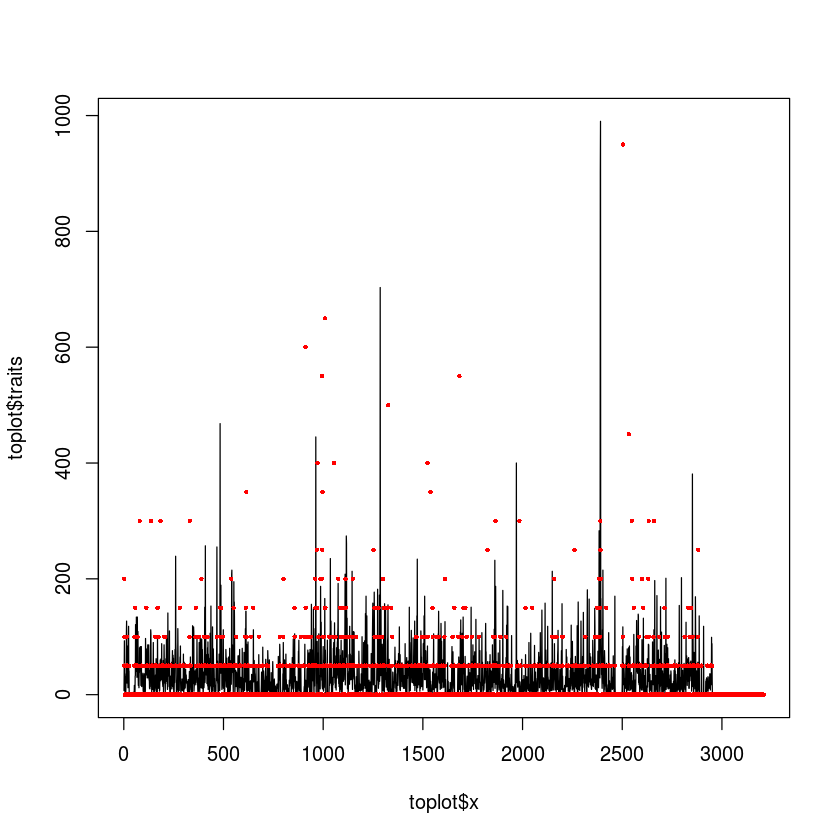

In [294]:
plot  (toplot$x, toplot$traits, type = "l")
points(toplot$x, toplot$n * 50, pch  = 16, cex = 0.5, col = "#ff0000")


In [282]:
str(bin2eqtl)

str(bin2gwas)

'data.frame':	25363 obs. of  9 variables:
 $ gbin  : chr  "chr1__" "chr1__" "chr1__" "chr1__" ...
 $ chrom : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ pos   : int  63735 233685 247916 250236 251627 531808 723819 752566 756308 768253 ...
 $ id    : chr  "VAR_1_63735_CCTA_C" "VAR_1_233685_GC_G" "VAR_1_247916_CAGG_C" "VAR_1_250236_CT_C" ...
 $ n     : int  -1 -1 0 0 0 0 0 0 -1 0 ...
 $ bin   : int  -1 -1 0 0 0 0 0 0 -1 0 ...
 $ from  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ to    : int  1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 ...
 $ traits: num  0 0 0 0 0 0 0 0 0 0 ...
'data.frame':	2678 obs. of  5 variables:
 $ chrom : chr  "chr1" "chr10" "chr11" "chr12" ...
 $ from  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ to    : int  1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 ...
 $ traits: int  7 19 96 65 187 19 31 47 157 27 ...
 $ gbin  : chr  "chr1_0_1000000" "chr10_0_1000000" "chr11_0_1000000" "chr12_0_1000000" ...


# OLD

# Combine into one single data frame
- nodes
- edges

## GWAS vs. GWAS

In [183]:
nodes_gwas     = data.frame(transcript_id = manifest$id, gene_id = manifest$id, gene_name = manifest$name, gene_type = "GWAs", transcript_type = "GWAs", phenotype = "gwas", color = "#ff0000")
nodes_gwas     = merge(nodes_gwas, data.frame(locus_id = rownames(loci), chrom = paste0("chr", loci$chrom), start = loci$from, end = loci$to))
#nodes_gwas$gws = FALSE
#
#for(transcript_id in colnames(loci2study))
#{
#    ids = rownames(loci2study[ loci2study[, transcript_id] == 1,])
#    nodes_gwas[ nodes_gwas$transcript_id == transcript_id & nodes_gwas$locus_id %in% ids, "gws"] = TRUE
#}
#
#nodes_gwas = nodes_gwas[ nodes_gwas$gws == TRUE, ]




In [184]:
edges_gwas_locus = lapply(loci$locus, function(locus)
{
    x                = coloc_gwas[ coloc_gwas$locus == locus, ]
    mycols           = c("transcript_id1", "transcript_id2", "type1", "type2", "pop", "id", "pp_snp", paste("PP.H", 0:4, ".abf", sep = ""))
    x$transcript_id1 = x$study1
    x$transcript_id2 = x$study2
    x$type1          = 0
    x$type2          = 0
    x$id             = x$variant_id
    x                = x[,mycols]
    
    return(x)
})

names(edges_gwas_locus) = loci$locus

## GWAS vs. QTL

In [185]:
edges_gwas_qtl_locus = lapply(loci$locus, function(locus)
{
    x                = coloc_qtls[ coloc_qtls$locus == locus, ]
    if(nrow(x) > 0)
    {
        mycols           = c("transcript_id1", "transcript_id2", "type1", "type2", "pop", "id", "pp_snp", paste("PP.H", 0:4, ".abf", sep = ""))
        x$transcript_id1 = x$transcript_id
        x$transcript_id2 = x$gwas
        x$type1          = x$type
        x$type2          = 0
        x                = x[,mycols]

        return(x)
    }else
    {
        return(data.frame())
    }
})

names(edges_gwas_qtl_locus) = loci$locus

# Create network for each locus

In [186]:
suppressPackageStartupMessages(library(igraph  ))
suppressPackageStartupMessages(library(corrplot))

In [187]:
loci$n_qtls = unlist(lapply(edges_gwas_qtl_locus, nrow))

In [200]:
create_network_locus = function(locus, threshold = 0.5)
{
    chrom           = paste0("chr", loci  [locus , "chrom" ])
    from            =               loci  [locus , "from"  ]
    to              =               loci  [locus , "to"    ]
    gwas_gwas       = edges_gwas_locus    [[locus]]
    gwas_qtls       = edges_gwas_qtl_locus[[locus]]
    transcript_ids  = sort(unique(c(gwas_qtls$transcript_id1, gwas_qtls$transcript_id2, gwas_gwas$transcript_id1, gwas_gwas$transcript_id2)))
    qtls_qtls       = edges_all[ edges_all$transcript_id1 %in% transcript_ids & edges_all$transcript_id2 %in% transcript_ids,]
    edges           = rbind(gwas_gwas, gwas_qtls, qtls_qtls)
    nodes           = rbind(nodes_all, nodes_gwas[ nodes_gwas$locus_id == locus, colnames(nodes_all)])
    edges           = edges[ edges$PP.H4.abf >= threshold,]
    nodes           = unique(nodes[ nodes$transcript_id %in% c(edges$transcript_id1, edges$transcript_id2),])
    network         = graph_from_data_frame(d = edges, vertices = nodes, directed = FALSE)
    
    return(list(nodes = nodes, edges = edges, network = network))
}

#locus = loci[2, "locus"]
x = create_network_locus("1_72412988_73058905", 0.9)

loci2net            = loci[ loci$n_qtls > 0 | loci$n_gwas > 1,]
loci_network        = lapply(loci2net$locus, function(locus){create_network_locus(locus, 0.9)})
names(loci_network) = loci2net$locus

saveRDS(loci_network, "pipeline/5.2.coloc_network/network_by_locus.rds")
fwrite(loci2net, "pipeline/5.2.coloc_network/loci2net.txt", sep = "\t", col.names = TRUE, row.names = FALSE)



# Get all associations (PP-h4 > 0.5 or PP-h3 > 0.5)

In [250]:
get_pps = function(locus, threshold = 0.5)
{
    chrom           = paste0("chr", loci  [locus , "chrom" ])
    from            =               loci  [locus , "from"  ]
    to              =               loci  [locus , "to"    ]
    gwas_gwas       = edges_gwas_locus    [[locus]]
    gwas_qtls       = edges_gwas_qtl_locus[[locus]]
    transcript_ids  = sort(unique(c(gwas_qtls$transcript_id1, gwas_qtls$transcript_id2, gwas_gwas$transcript_id1, gwas_gwas$transcript_id2)))
    qtls_qtls       = edges_all[ edges_all$transcript_id1 %in% transcript_ids & edges_all$transcript_id2 %in% transcript_ids,]
    edges           = rbind(gwas_gwas, gwas_qtls, qtls_qtls)
    nodes           = rbind(nodes_all, nodes_gwas[ nodes_gwas$locus_id == locus, colnames(nodes_all)])
    edges           = edges[ edges$PP.H4.abf >= threshold | edges$PP.H3.abf >= threshold,]
    nodes           = unique(nodes[ nodes$transcript_id %in% c(edges$transcript_id1, edges$transcript_id2),])
    
    return(list(nodes = nodes, edges = edges))
}

#locus = loci[2, "locus"]
x = get_pps("1_72412988_73058905", 0.5)

top_pps        = lapply(loci2net$locus, function(locus){get_pps(locus, 0.5)})
names(top_pps) = loci2net$locus

saveRDS(top_pps, "pipeline/5.2.coloc_network/top_pps.rds")


In [266]:
loci2net_count = as.data.frame(rbindlist(lapply(top_pps, function(x)
{
    nodes = x$nodes
    edges = x$edges
    out = data.frame(nodes = nrow(nodes), 
                     edges = nrow(unique(edges[, c("transcript_id1", "transcript_id2")])), 
                     nodes_09 = length(unique(c(edges[edges$PP.H4.abf >= 0.9, "transcript_id1"], edges[edges$PP.H4.abf >= 0.9, "transcript_id2"]))),
                     edges_09 = nrow(unique(edges[edges$PP.H4.abf >= 0.9, c("transcript_id1", "transcript_id2")]))
                    )
    for(phenotype in c("gwas", phenotypes$phenotype))
    {
        out[,paste("nodes", phenotype, sep = ".")] = nrow(nodes[nodes$phenotype == phenotype,])
    }
    
    return(out)
})), stringsAsFactors = FALSE)

loci2net_count = cbind(loci2net[,c("locus", "size", "chrom", "from", "to", "ids", "n_gwas")], loci2net_count)

fwrite(loci2net_count, "pipeline/5.2.coloc_network/loci2net_count.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


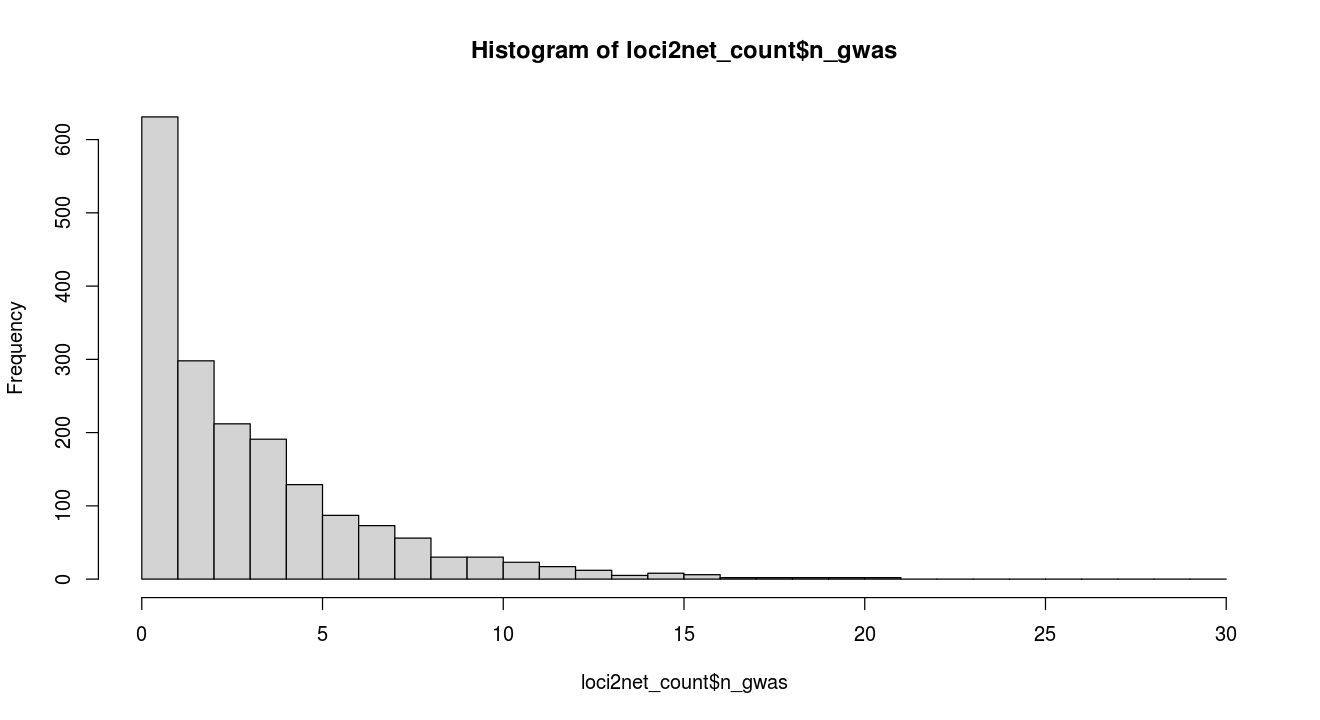

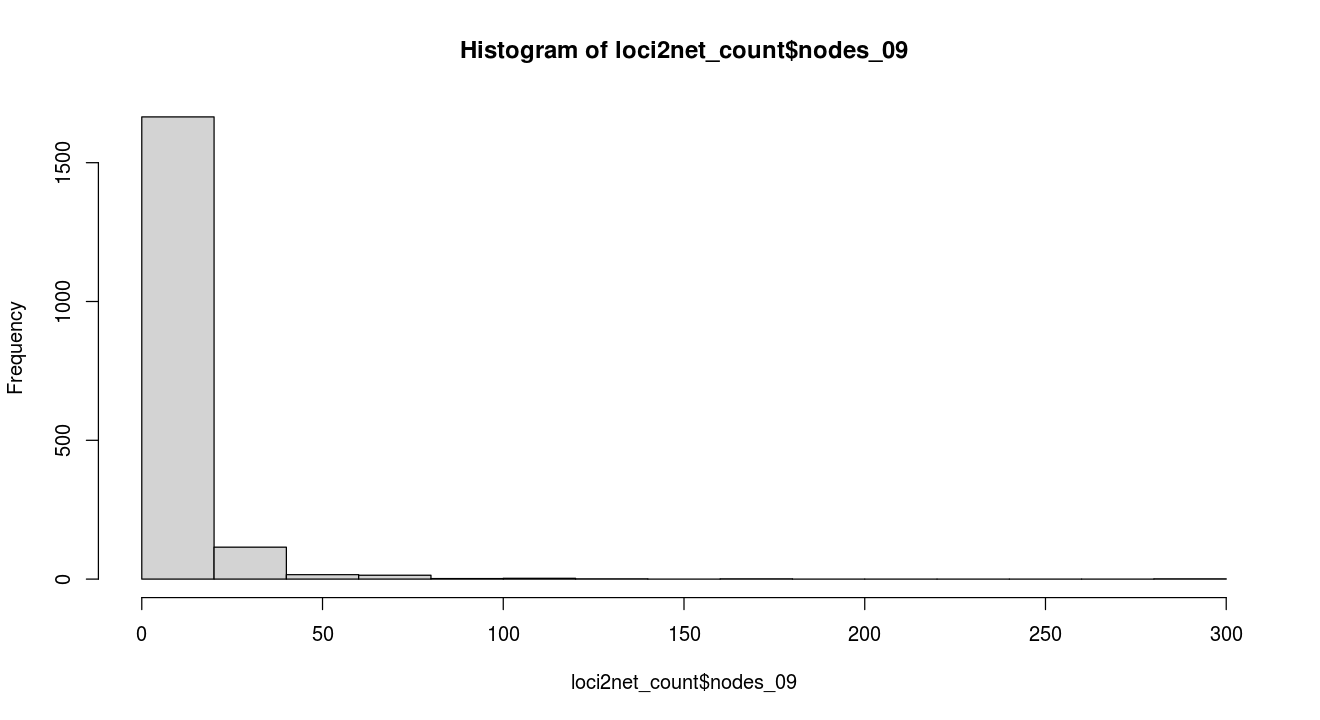

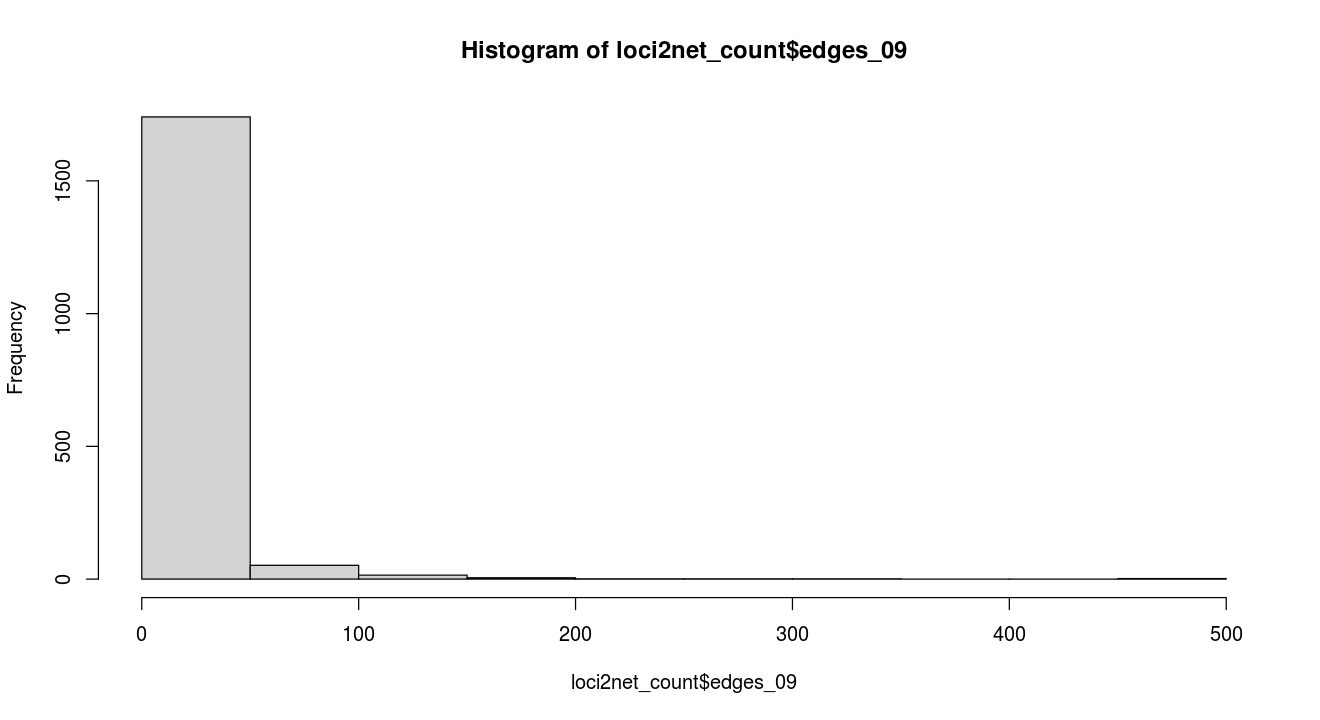

In [272]:
hist(loci2net_count$n_gwas, breaks = 0:30)
hist(loci2net_count$nodes_09)
hist(loci2net_count$edges_09)



In [273]:
head(loci2net_count[order(loci2net_count$edges_09, decreasing = TRUE),])

,locus,size,chrom,from,to,ids,n_gwas,nodes,edges,nodes_09,edges_09,nodes.gwas,nodes.rna,nodes.isoform,nodes.atac,nodes.chip
,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
6_25044242_33934568,6_25044242_33934568,8890326,6,25044242,33934568,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,continuous-102-both_sexes-irnt,continuous-20022-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-401-both_sexes,phecode-411.4-both_sexes",19,406,15752,286,473,27,161,163,18,37
17_40144007_48070076,17_40144007_48070076,7926069,17,40144007,48070076,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,continuous-102-both_sexes-irnt,continuous-12340-both_sexes-irnt,continuous-20022-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-401-both_sexes,phecode-411.2-both_sexes,phecode-411.4-both_sexes",21,279,4844,166,461,27,104,76,40,32
16_14277712_16384360,16_14277712_16384360,2106648,16,14277712,16384360,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,continuous-102-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",11,89,1567,75,321,17,25,34,9,4
1_965800_2544414,1_965800_2544414,1578614,1,965800,2544414,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",7,126,2644,85,269,15,50,32,10,19
19_43889535_47004800,19_43889535_47004800,3115265,19,43889535,47004800,"biomarkers-30600-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,categorical-20003-both_sexes-1141146234,continuous-102-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-411.2-both_sexes,phecode-411.4-both_sexes",18,164,3145,107,215,24,61,48,14,17
22_24141101_24503541,22_24141101_24503541,362440,22,24141101,24503541,biomarkers-30870-both_sexes-irnt,1,44,415,36,200,7,12,6,8,11


# plot networks

In [277]:
plot_subgraph = function(locus)
{
    network_locus = loci_network[[locus]]
    nodes         = network_locus$nodes
    edges         = network_locus$edges
    x             = network_locus$network
    coord         = nodes[nodes$transcript_id %in% names(V(x)),]
    chrom         = unique(coord$chrom)
    from          = min   (coord$start)
    to            = max   (coord$end  )
    ids           = nodes
    ids           = ids[order(ids$start),]
    
    toplot = as.data.frame(matrix(0, nrow = nrow(ids), ncol = nrow(ids), dimnames = list(ids$transcript_id, ids$transcript_id)))
    
    for(ii in 1:(nrow(ids)-1))
    {
        id1 = ids[ii, "transcript_id"]
        
        for(jj in (ii+1):nrow(ids))
        {
            id2  = ids[jj, "transcript_id"]
            this = edges[ (edges$transcript_id1 == id1 & edges$transcript_id2 == id2) | (edges$transcript_id1 == id2 & edges$transcript_id2 == id1),]
            
            if(nrow(this) > 0)
            {
                #toplot[c(id1, id2), c(id2, id1)] =  max(this[, "PP.H4.abf"])
                toplot[id1, id2] =  max(this[, "PP.H4.abf"])
            }
        }
        toplot[ii,ii] = 1
    }
    
    toplot           = as.matrix(toplot)
    rownames(toplot) = ids$gene_name
    colnames(toplot) = ids$gene_name
    
    layout(rbind(1:2))
    corrplot(toplot, method = "color", tl.pos = "t", tl.cex = 0.8, tl.col = "#000000")
    plot.igraph(x, vertex.label = V(x)$gene_name, main = locus)
    
    #return(toplot)
}
options(repr.plot.width = 20, repr.plot.height = 8)

toplot = loci2net_count[ loci2net_count$edges_09 > 0,]

pdf(file = "pipeline/5.2.coloc_network/network_loci.pdf", width = 20, height = 9)
invisible(lapply(toplot[order(toplot$edges_09, decreasing = TRUE), "locus"], plot_subgraph))

dev.off()

#toplot = plot_subgraph(decomposed, 409)


png 
  2